In [1]:
import py7zr
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier


2024-06-11 23:00:45.912830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Extract Images

In [2]:
# !pip install py7zr

In [3]:
english_7z = 'english.7z'
extract_path = 'english'
# os.makedirs(extract_path, exist_ok=True)
# with py7zr.SevenZipFile(english_7z, mode='r') as z:
#     z.extractall(path=extract_path)
print(f"Files have been extracted to {extract_path}")

Files have been extracted to english


# 2. Data Preprocessing

In [4]:
df = pd.read_csv('english.csv')


In [5]:
def load_and_preprocess_image(image_path, target_size=(64, 64)):  # Updated to 64x64
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image at path: {image_path}")
        return None
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0
    return image

In [6]:
images = []
labels = []
for index, row in df.iterrows():
    image_path = os.path.join(extract_path, row['image'])  # Corrected path
    if not os.path.exists(image_path):
        print(f"File does not exist: {image_path}")
        continue
    image = load_and_preprocess_image(image_path)
    if image is not None:
        images.append(image)
        labels.append(row['label'])

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Create DataFrame
df = pd.DataFrame({'image': [img.flatten() for img in images], 'label': labels_encoded})


In [7]:
df

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
...,...,...
3405,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61
3406,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61
3407,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61
3408,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61


In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)

# Extract training and testing data
X_train_flat = np.array([img for img in train_df['image']])
X_test_flat = np.array([img for img in test_df['image']])
y_train_flat = train_df['label'].values
y_test_flat = test_df['label'].values

# Reshape images for CNN
X_train_cnn = X_train_flat.reshape(-1, 64, 64, 1)
X_test_cnn = X_test_flat.reshape(-1, 64, 64, 1)

# Convert labels to categorical for CNN
y_train_cnn = to_categorical(y_train_flat, num_classes=62)  # Updated to 62 classes
y_test_cnn = to_categorical(y_test_flat, num_classes=62)

print(f'Training set shape (CNN): {X_train_cnn.shape}')
print(f'Test set shape (CNN): {X_test_cnn.shape}')
print(f'Training set shape (SVM/k-NN): {X_train_flat.shape}')
print(f'Test set shape (SVM/k-NN): {X_test_flat.shape}')

Training set shape (CNN): (2728, 64, 64, 1)
Test set shape (CNN): (682, 64, 64, 1)
Training set shape (SVM/k-NN): (2728, 4096)
Test set shape (SVM/k-NN): (682, 4096)


# Training and Evaluating Models

### Training SVM


In [9]:
# Train SVM model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train_flat, y_train_flat)

# Evaluate SVM model
y_pred_svm = svm_model.predict(X_test_flat)
svm_accuracy = accuracy_score(y_test_flat, y_pred_svm)
print(f'SVM Accuracy: {svm_accuracy}')
print(classification_report(y_test_flat, y_pred_svm))
print(confusion_matrix(y_test_flat, y_pred_svm))

SVM Accuracy: 0.3973607038123167
              precision    recall  f1-score   support

           0       0.29      0.62      0.40         8
           1       0.41      0.35      0.38        20
           2       0.36      0.27      0.31        15
           3       0.50      0.44      0.47         9
           4       0.30      0.21      0.25        14
           5       0.11      0.11      0.11         9
           6       0.56      0.50      0.53        10
           7       0.00      0.00      0.00         0
           8       0.46      0.55      0.50        11
           9       0.57      0.31      0.40        13
          10       0.60      0.35      0.44        17
          11       0.33      0.40      0.36        10
          12       0.75      1.00      0.86         6
          13       0.50      0.44      0.47         9
          14       0.54      0.64      0.58        11
          15       0.57      0.67      0.62         6
          16       0.50      0.64      0.56     

/Users/johnnyhuang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnnyhuang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnnyhuang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Training KNN

In [10]:
# Train k-NN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train_flat, y_train_flat)

# Evaluate k-NN model
y_pred_knn = knn_model.predict(X_test_flat)
knn_accuracy = accuracy_score(y_test_flat, y_pred_knn)
print(f'k-NN Accuracy: {knn_accuracy}')
print(classification_report(y_test_flat, y_pred_knn))
print(confusion_matrix(y_test_flat, y_pred_knn))

k-NN Accuracy: 0.3519061583577713
              precision    recall  f1-score   support

           0       0.10      0.62      0.17         8
           1       0.21      0.60      0.32        20
           2       0.60      0.60      0.60        15
           3       0.19      0.44      0.27         9
           4       0.45      0.36      0.40        14
           5       0.09      0.11      0.10         9
           6       0.33      0.50      0.40        10
           7       0.00      0.00      0.00         0
           8       0.86      0.55      0.67        11
           9       0.33      0.23      0.27        13
          10       0.64      0.41      0.50        17
          11       0.25      0.20      0.22        10
          12       0.31      0.67      0.42         6
          13       0.62      0.56      0.59         9
          14       0.36      0.36      0.36        11
          15       0.27      0.67      0.38         6
          16       0.50      0.18      0.27    

/Users/johnnyhuang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnnyhuang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnnyhuang/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Training CNN

In [11]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),  # Updated to 64x64
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(62, activation='softmax')  # Updated to 62 classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, validation_data=(X_test_cnn, y_test_cnn))


Epoch 1/10


/Users/johnnyhuang/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.0274 - loss: 4.1458 - val_accuracy: 0.1496 - val_loss: 3.5262
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.2502 - loss: 3.0830 - val_accuracy: 0.3636 - val_loss: 2.5241
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.5001 - loss: 1.9173 - val_accuracy: 0.4663 - val_loss: 1.9999
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.6647 - loss: 1.2786 - val_accuracy: 0.5176 - val_loss: 1.7906
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.7889 - loss: 0.8017 - val_accuracy: 0.5484 - val_loss: 1.7524
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8420 - loss: 0.5610 - val_accuracy: 0.5587 - val_loss: 1.8250
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9081 - loss: 0.3624 - val_accuracy: 0.5865 - val_loss: 1.7956
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9400 - loss: 0.2168 - val_accuracy: 0.5997 - val_loss: 1.

22/22 - 0s - 16ms/step - accuracy: 0.6012 - loss: 2.1270
CNN Accuracy: 0.6011730432510376


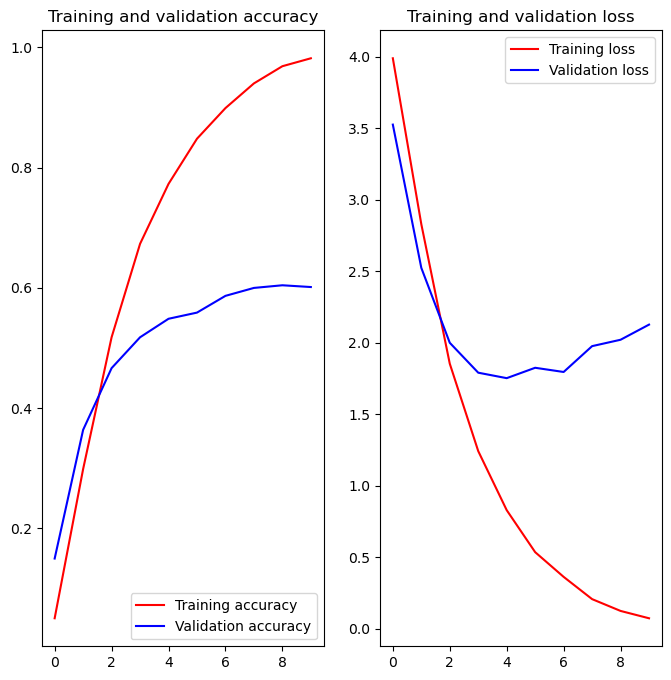

In [12]:
# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=2)
print(f'CNN Accuracy: {cnn_accuracy}')

# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc='upper right')

    plt.show()

plot_history(cnn_history)

# Comparing Model

In [13]:
print(f'SVM Accuracy: {svm_accuracy}')
print(f'k-NN Accuracy: {knn_accuracy}')
print(f'CNN Accuracy: {cnn_accuracy}')


SVM Accuracy: 0.3973607038123167
k-NN Accuracy: 0.3519061583577713
CNN Accuracy: 0.6011730432510376
